# Import libraries

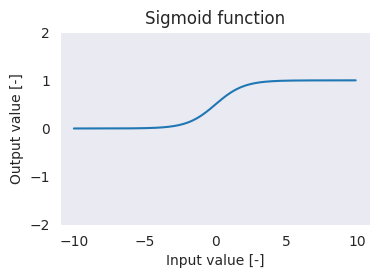

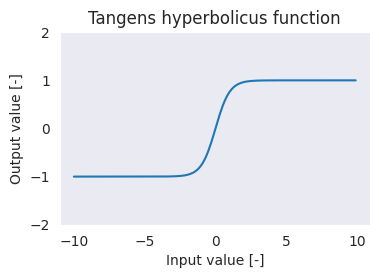

In [1]:
# Surpresses printing and plotting from other notebook
import matplotlib
import io
import sys

original_stdout = sys.stdout
sys.stdout = io.StringIO()

%run evolution_strategies.ipynb
%run assets/neural_network.ipynb

sys.stdout = original_stdout

In [2]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from io import BytesIO
from ipywidgets import widgets
from matplotlib.colors import Normalize
import gymnasium as gym
import seaborn as sns

np.set_printoptions(precision=4, suppress=True) # for better printing
sns.set_style("darkgrid")

# Problem: Walker 2D

In [3]:
# Algorithm parameters
population_size = 256

In [4]:
environments = gym.make_vec('Pendulum-v1', num_envs=population_size)

# shape of observation_space is defined as (population_size, observation_size)
observation_size = environments.observation_space.shape[1]

# shape of action_space is defined as (population_size, action_size)
action_size = environments.action_space.shape[1]

print(f"Observation size: {observation_size}")
print(f"Actions size: {action_size}")

Observation size: 3
Actions size: 1


### Define Neural Network as Policy

In [5]:
# Test forward pass
input_size = observation_size
hidden_1_size = 16
hidden_2_size = 8
output_size = action_size

# Initialise neural network
policy = MLP(input_size, hidden_1_size, hidden_2_size, output_size)

flat_params = policy.flatten_params()
num_parameters = len(flat_params)

print(f"Number of parameters per candidate: {num_parameters}")

Number of parameters per candidate: 209


### Initialise population of neural networks

In [6]:
input_size = observation_size
hidden_1_size = 8
hidden_2_size = 4
output_size = action_size

population = []
for i in range(population_size):
    nn = MLP(input_size, hidden_1_size, hidden_2_size, output_size)
    params = nn.flatten_params()
    population.append(params)

population = np.array(population)
print(f"Population shape: {population.shape}")

Population shape: (256, 73)


We define a function which helps infer the actions of each network from each corresponding environment observation.

In [7]:
def get_actions(population, observations):
    population_size = population.shape[0]
    
    actions = []
    for i in range(population_size):
        candidate_params = population[i, :]
        single_observation = observations[i, :]
        
        nn.unflatten_params(candidate_params)
        single_action = nn.forward(single_observation)
    
        actions.append(single_action)
    
    return np.array(actions)

### Step 4: Evaluate $\lambda$ offspring (Gym Environment)

In [8]:
def evaluate_population_gym(population, environments, num_evaluation_steps):
    accumulated_rewards = np.zeros((population.shape[0],))
    observations, infos = environments.reset()

    for step in range(num_evaluation_steps):
        # get actions from neural networks
        actions = get_actions(population, observations)
        
        # execute the action in environment
        observations, rewards, terminations, truncations, infos = environments.step(actions)

        accumulated_rewards += rewards
        
    return accumulated_rewards

### Execute Evolution

In [10]:
# Environment
num_evaluation_steps = 200 # defined earlier for environment
envs = environments # defined earlier for environment

# ES parameters
num_generations = 200
mutation_sigma_init = 1.0
population_size = population_size # defined earlier for environment
num_parents = 64

sigma_decay = 0.9999 # [0.0, 1.0]
sigma_limit = 0.1

# Logging
fitness_log = []
population_log = []

# Evolution
mean_vector = initialise_mean(num_parameters)
mutation_sigma = mutation_sigma_init

best_candidate = np.zeros((num_parameters,))
best_fitness = 0.0

# Control of mutation rate
def exp_decay(sigma, sigma_decay, sigma_limit):
    sigma = sigma * sigma_decay
    return np.max((sigma_limit, sigma))
    
for gen in range(num_generations):
    population = generate_mutated_offspring(population_size, mean_vector, mutation_sigma)
    fitness = evaluate_population_gym(population, envs, num_evaluation_steps)
    
    # For visualisation
    # population_log.append(population)
    fitness_log.append(fitness)
    
    parents_population, parents_fitness = sort_and_select_parents(population, fitness, num_parents)
    mean_vector = update_population_mean(parents_population, parents_fitness)
    
    if parent_fitness[0] > best_fitness:
        best_candidate = parents_population[0, :]
        best_fitness = parent_fitness[0]
    
    mutation_sigma = exp_decay(mutation_sigma, sigma_decay, sigma_limit)
    
    if gen % 10 == 0:
        print(f"Best fitness in generation {gen}: {np.max(fitness)}")

Best fitness in generation 0: -651.8020428477976
Best fitness in generation 10: -763.4854790285574
Best fitness in generation 20: -387.6674519314806
Best fitness in generation 30: -3.77641390258409
Best fitness in generation 40: -755.0295531738525
Best fitness in generation 50: -674.6419016705406
Best fitness in generation 60: -745.1351781402021
Best fitness in generation 70: -644.8430559362461
Best fitness in generation 80: -605.4335934604527
Best fitness in generation 90: -664.0265571597816
Best fitness in generation 100: -634.205719362026
Best fitness in generation 110: -657.2717089037183
Best fitness in generation 120: -680.9146130893926
Best fitness in generation 130: -727.8226620396272
Best fitness in generation 140: -724.9360937335168
Best fitness in generation 150: -640.3055195136208
Best fitness in generation 160: -636.040891476576
Best fitness in generation 170: -642.4337085348446
Best fitness in generation 180: -668.7907212308388
Best fitness in generation 190: -636.64490438

### Visualize best policy

In [9]:
# Calculate mean, min, and max fitness for each generation
mean_fitness = np.mean(fitness_log, axis=1)
min_fitness = np.min(fitness_log, axis=1)
max_fitness = np.max(fitness_log, axis=1)

# Generate the generations array
generations = np.arange(len(mean_fitness))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(generations, mean_fitness, label='Mean Fitness', linestyle="dashed", color="#FF0000", alpha=0.4)
plt.plot(generations, max_fitness, label='Max Fitness', color="#B51F1F")
plt.plot(generations, min_fitness, label='Min Fitness', linestyle="dashed", color="#007480", alpha=0.4)
plt.fill_between(generations, min_fitness, max_fitness, alpha=0.2, label='Min-Max Range')

plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'fitness_log' is not defined

In [10]:
# Create a widget for displaying the environment
image_widget = widgets.Image(format='jpeg')

# Display the widget
display(image_widget)

def update_image(env):
    img = env.render()
    img = Image.fromarray(img)
    with BytesIO() as output:
        img.save(output, format="JPEG")
        image_data = output.getvalue()
        image_widget.value = image_data

# Run and update environment
for _ in range(num_evaluation_steps):
    action = get_actions(population, obeservation)
    observation, reward, terminated, truncated, info = env.step(action)
    
    if terminated or truncated:
        observation, info = env.reset()
    
    update_image(env)
    clear_output(wait=True)

env.close()

Image(value=b'', format='jpeg')

NameError: name 'num_evaluation_steps' is not defined